<a href="https://colab.research.google.com/github/cpeluso/HW2-Image-Classification/blob/master/HW2_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Install requirements**

In [0]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

**Import libraries**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import alexnet

from PIL import Image
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

**Set Arguments**

In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

**Define Data Preprocessing**

In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes tensor with mean and standard deviation
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                    
])

**Prepare Dataset**

In [0]:
from torchvision.datasets import VisionDataset
from random import shuffle, randint
from PIL import Image
import numpy as np
import os
import os.path
import sys


def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def get_index(annotations, tuple):
  index = 0
  for annotation in annotations:
    if annotation == tuple:
      return index
    else:
      index += 1

class Caltech(VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None):
        super(Caltech, self).__init__(root, transform=transform, target_transform=target_transform)

        file = open("./Caltech101/" + split + ".txt", "r")
        annotations = file.readlines()

        # This defines the split you are going to use
        # (split files are called 'train.txt' and 'test.txt')
        self.root = root
        self.split = split 
        self.annotations = [annotation for annotation in annotations if "BACKGROUND" not in annotation]

        classes = list(set([row.split("/")[0] for row in self.annotations]))
        class_index = 0
        class_indices = {}

        for class_string in classes:
          class_indices[class_string] = class_index
          class_index += 1

        self.class_indices = class_indices

        '''
        - Here you should implement the logic for reading the splits files and accessing elements
        - If the RAM size allows it, it is faster to store all data in memory
        - PyTorch Dataset classes use indices to read elements
        - You should provide a way for the __getitem__ method to access the image-label pair
          through the index
        - Labels should start from 0, so for Caltech you will have lables 0...100 (excluding the background class) 
        '''
        pass

    def train_eval_split(self):

        if self.split != "train":
          return _, _

        # Get set of classes
        labels = list(set([row.split("/")[0] for row in self.annotations]))

        train_indices = []
        eval_indices = []

        for label in labels:
          # Get all samples of the current class
          samples = np.array([sample for sample in self.annotations if sample.split("/")[0] == label])
          # Shuffle the data
          shuffle(samples)

          # Assign the same portion of data to train and evaluation set
          length=len(samples)

          if length % 2 != 0:
            train_length = length/2 + randint(0,1)
          else:
            train_length = length/2

          train_data = samples[: int(train_length)]
          eval_data = samples[int(train_length):]

          # Append partial indices
          train_partial_indices = []
          eval_partial_indices = []

          for data in train_data:
            train_partial_indices.append(get_index(self.annotations, data))

          for data in eval_data:
            eval_partial_indices.append(get_index(self.annotations, data))

          train_indices.append(train_partial_indices)
          eval_indices.append(eval_partial_indices)

        # Flat out the lists of indices
        train_indices = [item for sublist in train_indices for item in sublist]
        eval_indices = [item for sublist in eval_indices for item in sublist]

        return train_indices, eval_indices
        pass

    def __getitem__(self, index):
        '''
        __getitem__ should access an element through its index
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        '''
        img_path = os.path.join(self.root, self.annotations[index].rstrip())
        label = str(self.annotations[index]).split("/")[0]
        image = pil_loader(img_path)

        # Applies preprocessing when accessing the image
        if self.transform is not None:
            image = self.transform(image)

        return (image, torch.tensor(self.class_indices[label]))
        pass

    def __len__(self): 
        '''
        The __len__ method returns the length of the dataset
        It is mandatory, as this is used by several other components
        '''
        length = len(self.annotations)
        return length
        pass

In [7]:
# Clone github repository with data
if not os.path.isdir('./Caltech101'):
  !git clone https://github.com/MachineLearning2020/Homework2-Caltech101.git
  !mv 'Homework2-Caltech101' 'Caltech101'

DATA_DIR = 'Caltech101/101_ObjectCategories'
#from Caltech101.caltech_dataset import Caltech

# Prepare Pytorch train/test Datasets
train_dataset = Caltech(DATA_DIR, split='train', transform=train_transform)
test_dataset = Caltech(DATA_DIR, split='test', transform=eval_transform)

# split the indices for your train split and eval split
train_indexes, val_indexes = train_dataset.train_eval_split()

val_dataset = Subset(train_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes) 

# Check dataset sizes
print('Train Dataset: {}'.format(len(train_dataset)))
print('Valid Dataset: {}'.format(len(val_dataset)))
print('Test Dataset: {}'.format(len(test_dataset)))

Cloning into 'Homework2-Caltech101'...
remote: Enumerating objects: 9256, done.
remote: Total 9256 (delta 0), reused 0 (delta 0), pack-reused 9256
Receiving objects: 100% (9256/9256), 129.48 MiB | 28.87 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (9149/9149), done.
Train Dataset: 2895
Valid Dataset: 2889
Test Dataset: 2893


**Prepare Dataloaders**

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

**Prepare Network**

In [0]:
net = alexnet() # Loading AlexNet model

# AlexNet has 1000 output neurons, corresponding to the 1000 ImageNet's classes
# We need 101 outputs for Caltech-101
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) # nn.Linear in pytorch is a fully connected layer
                                                 # The convolutional layer is nn.Conv2d

# We just changed the last layer of AlexNet with a new fully connected layer with 101 outputs
# It is strongly suggested to study torchvision.models.alexnet source code

**Prepare Training**

In [0]:
# Define loss function
criterion = nn.CrossEntropyLoss() # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of AlexNet
# (nn.Module objects, like AlexNet, implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers: look at alexnet's source code ;) 
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters of AlexNet

# Define optimizer
# An optimizer updates the weights based on loss
# We use SGD with momentum
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

**Train Neural Network from scratch**


In [0]:
# Function called every training epoch to evaluate the accuracy on the validation set

def evaluate_neural_network_on_validation_set(net):
  net.train(False) # Set Network to evaluation mode

  running_corrects = 0
  for images, labels in val_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)

    # Update Corrects
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate Accuracy
  accuracy = running_corrects / float(len(val_dataset))

  print('Validation Accuracy: {}'.format(accuracy))
  print("\n")

  return accuracy

In [0]:
# By default, everything is loaded to cpu
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

cudnn.benchmark # Calling this optimizes runtime

current_step = 0
# Start iterating over the epochs
for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  # Iterate over the dataset
  for images, labels in train_dataloader:
    # Bring data over the device of choice
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() # Sets module in training mode

    # PyTorch, by default, accumulates gradients after each backward pass
    # We need to manually set the gradients to zero before starting a new iteration
    optimizer.zero_grad() # Zero-ing the gradients

    # Forward pass to the network
    outputs = net(images)

    # Compute loss based on output and ground truth
    loss = criterion(outputs, labels)

    # Log loss
    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    # Compute gradients for each layer and update weights
    loss.backward()  # backward pass: computes gradients
    optimizer.step() # update weights based on accumulated gradients

    current_step += 1

  # Evaluate network on validation set
  evaluate_neural_network_on_validation_set(net) 

  # Step the scheduler
  scheduler.step()

**Train Neural Network from scratch with Hyperparameters Tuning**



 Hyperparameter set:
(0.01, 15, 30)
Starting epoch 1/30, LR = [0.01]
Step 0, Loss 4.627104759216309
Step 10, Loss 4.614486217498779
Validation Accuracy: 0.09200968523002422




Starting epoch 2/30, LR = [0.01]
Step 20, Loss 4.595088005065918
Validation Accuracy: 0.09200968523002422




Starting epoch 3/30, LR = [0.01]
Step 30, Loss 4.563417911529541
Validation Accuracy: 0.09200968523002422




Starting epoch 4/30, LR = [0.01]
Step 40, Loss 4.414036750793457
Validation Accuracy: 0.09200968523002422




Starting epoch 5/30, LR = [0.01]
Step 50, Loss 4.314484119415283
Validation Accuracy: 0.13974403320650294




Starting epoch 6/30, LR = [0.01]
Step 60, Loss 4.10892915725708
Validation Accuracy: 0.09200968523002422




Starting epoch 7/30, LR = [0.01]
Step 70, Loss 4.196255683898926
Validation Accuracy: 0.09339328951919751




Starting epoch 8/30, LR = [0.01]
Step 80, Loss 4.082356929779053
Validation Accuracy: 0.15081286751988932




Starting epoch 9/30, LR = [0.01]
Step 90, Loss 4.1228

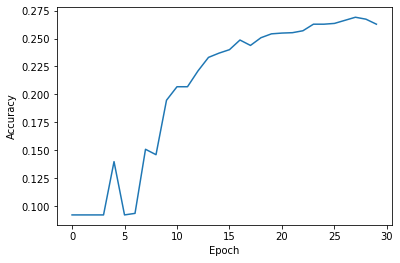

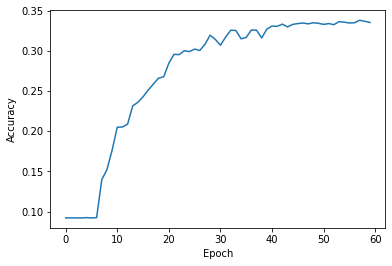

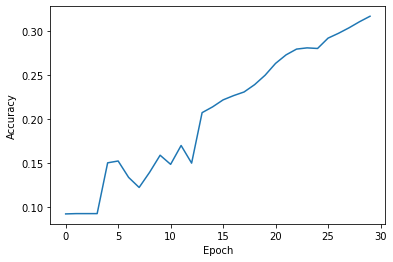

In [0]:
hyperparameters_sets = [
                        (0.01, 15, 30),
                        (0.01, 20, 60),
                        (0.1, 15, 30)
]
# (LR, STEP_SIZE, NUM_EPOCHS)

accuracies = dict()
losses = dict()
nets_best_accuracy = dict()

for hyperparameter_set in hyperparameters_sets:
  LR = hyperparameter_set[0]
  STEP_SIZE = hyperparameter_set[1]
  NUM_EPOCHS = hyperparameter_set[2]

  print("\n Hyperparameter set:")
  print(hyperparameter_set)
  accuracies[hyperparameter_set] = []

  # Prepare Network

  net = alexnet() 
  net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

  # Prepare Training

  criterion = nn.CrossEntropyLoss() 
  parameters_to_optimize = net.parameters() 
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

  net = net.to(DEVICE) 
  cudnn.benchmark 

  current_step = 0
  best_accuracy = float(0)
  filename = "model_" + str(LR).replace(".", "") + str(STEP_SIZE) + str(NUM_EPOCHS) +".pth"

  for epoch in range(NUM_EPOCHS):
    print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

    for images, labels in train_dataloader:

      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      net.train()

      optimizer.zero_grad()

      outputs = net(images)

      loss = criterion(outputs, labels)

      if current_step % LOG_FREQUENCY == 0:
        print('Step {}, Loss {}'.format(current_step, loss.item()))

      loss.backward()  
      optimizer.step() 

      current_step += 1

    scheduler.step()
    
    accuracy = evaluate_neural_network_on_validation_set(net) 
    accuracies[hyperparameter_set].append( (epoch, accuracy) )
    losses[hyperparameter_set].append( (epoch, loss.item()))
    
    # Save the model if this epoch produced the best accuracy value on validation set
    if accuracy > best_accuracy:
      torch.save(net.state_dict(), filename)
      nets_best_accuracy[hyperparameter_set] = (epoch, accuracy, filename)
      best_accuracy = accuracy

    print("\n")

  df = pd.DataFrame(accuracies[hyperparameter_set])
  df = df.astype(float)
  df.columns=['Epoch','Accuracy']

  plt.figure()  
  sns.lineplot(x='Epoch',y='Accuracy',data=df) 

In [0]:
print(nets_best_accuracy)


**Validation on Neural Network trained from scratch**

In [0]:
max_acc = 0
max_acc_model_filename = ""
for k in nets_best_accuracy:
  if nets_best_accuracy[k][1] > max_acc:
    max_acc = nets_best_accuracy[k][1]
    max_acc_model_filename = nets_best_accuracy[k][2]

print(max_acc_model_filename)
net = alexnet()
net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 
net.load_state_dict(torch.load(max_acc_model_filename))


net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(val_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(val_dataset))

print('Validation Accuracy: {}'.format(accuracy))

model_0012060.pth


100%|██████████| 12/12 [00:13<00:00,  1.13s/it]

Validation Accuracy: 0.3386371497751643


**Test on Neural Network trained from scratch**

In [0]:
net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
net.train(False) # Set Network to evaluation mode

running_corrects = 0
for images, labels in tqdm(test_dataloader):
  images = images.to(DEVICE)
  labels = labels.to(DEVICE)

  # Forward Pass
  outputs = net(images)

  # Get predictions
  _, preds = torch.max(outputs.data, 1)

  # Update Corrects
  running_corrects += torch.sum(preds == labels.data).data.item()

# Calculate Accuracy
accuracy = running_corrects / float(len(test_dataset))

print('Test Accuracy: {}'.format(accuracy))

100%|██████████| 12/12 [00:14<00:00,  1.23s/it]

Test Accuracy: 0.3370203940546146


**Transfer Learning**

In [12]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

NUM_CLASSES = 102 # 101 + 1: There is an extra Background class that should be removed 

BATCH_SIZE = 256     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.001            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 30      # Total number of training epochs (iterations over dataset)
STEP_SIZE = 20       # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 10

net = alexnet(pretrained=True)

train_transform = transforms.Compose([transforms.Resize(256),      # Resizes short size of the PIL image to 256
                                      transforms.CenterCrop(224),  # Crops a central square patch of the image
                                                                   # 224 because torchvision's AlexNet needs a 224x224 input!
                                                                   # Remember this when applying different transformations, otherwise you get an error
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])

eval_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                           std=[0.229, 0.224, 0.225]) # Normalizes tensor with mean and standard deviation
])

net.classifier[6] = nn.Linear(4096, NUM_CLASSES) 

criterion = nn.CrossEntropyLoss()

parameters_to_optimize = net.parameters() 

optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

net = net.to(DEVICE)

cudnn.benchmark 

current_step = 0

for epoch in range(NUM_EPOCHS):
  print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))

  for images, labels in train_dataloader:

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    net.train() 

    optimizer.zero_grad() 

    outputs = net(images)

    loss = criterion(outputs, labels)

    if current_step % LOG_FREQUENCY == 0:
      print('Step {}, Loss {}'.format(current_step, loss.item()))

    loss.backward() 
    optimizer.step() 

    current_step += 1

  # Evaluate network on validation set
  evaluate_neural_network_on_validation_set(net) 

  # Step the scheduler
  scheduler.step()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



Starting epoch 1/30, LR = [0.001]
Step 0, Loss 4.779001235961914
Step 10, Loss 3.390082836151123
Validation Accuracy: 0.2803738317757009


Starting epoch 2/30, LR = [0.001]
Step 20, Loss 2.818577289581299
Validation Accuracy: 0.4451367255105573


Starting epoch 3/30, LR = [0.001]
Step 30, Loss 2.236776351928711
Validation Accuracy: 0.5614399446175147


Starting epoch 4/30, LR = [0.001]
Step 40, Loss 1.4543665647506714
Validation Accuracy: 0.6690896503980616


Starting epoch 5/30, LR = [0.001]
Step 50, Loss 0.9856462478637695
Validation Accuracy: 0.7431637244721356


Starting epoch 6/30, LR = [0.001]
Step 60, Loss 0.6561831831932068
Validation Accuracy: 0.7739702319141571


Starting epoch 7/30, LR = [0.001]
Step 70, Loss 0.5101737976074219
Validation Accuracy: 0.7857390100380754


Starting epoch 8/30, LR = [0.001]
Step 80, Loss 0.35854822397232056
Validation Accuracy: 0.803392177223953


Starting epoch 9/30, LR = [0.001]
Step 90, Loss 0.24973899126052856
Validation Accuracy: 0.80719972